## Install All Dependencies


In [20]:
!pip install lpips
!pip install torchvision
!pip install piq
!pip install scikit-image
!pip install pytorch-msssim

## Imports & Load CIFAR-10

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from pytorch_msssim import ssim
import lpips
from piq import gmsd
from skimage.color import rgb2lab, deltaE_ciede2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [22]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)


## Binary Latent Autoencoder

In [23]:
class BinarizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return (x > 0).float()
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

binarize = BinarizeSTE.apply


class BinaryAutoencoder(nn.Module):
    def __init__(self, latent_dim=256, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
        )
        self.fc_enc = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        # Encode to latent vector
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        z = self.fc_enc(x)
        z = torch.tanh(z)
        z = z + self.epsilon * torch.randn_like(z)

        # Binary latent with STE gradient
        z_bin = binarize(z)
        z_bin = z + (z_bin - z).detach()

        # Decode
        x = self.fc_dec(z_bin)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)

        return x, z_bin

## Loss Functions (MSE, MAE, SSIM, LPIPS)

In [24]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
lpips_loss = lpips.LPIPS(net="alex").to(device)

def to_lpips_range(x):
    # LPIPS expects inputs in [-1, 1]
    return x * 2 - 1

def ssim_loss(x, y):
    # 1 - SSIM, with size_average=True for scalar loss
    return 1 - ssim(x, y, data_range=1.0, size_average=True)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


## Distance Evaluation Metrics

In [25]:
def cosine_distance(x, y):
    x_flat = x.view(x.size(0), -1)
    y_flat = y.view(y.size(0), -1)
    return (1 - torch.nn.functional.cosine_similarity(x_flat, y_flat, dim=1)).mean()

def gmsd_distance(x, y):
    return gmsd(x, y).mean()

def deltaE2000_distance(img, recon):
    """
    Computes mean DeltaE2000 over batch.
    img, recon: torch tensors in [0,1], shape [B,3,H,W]
    """
    img_np = img.permute(0,2,3,1).cpu().numpy()
    rec_np = recon.permute(0,2,3,1).cpu().numpy()

    total = 0
    for i in range(img_np.shape[0]):
        # Convert to Lab (skimage expects 0-1 input for rgb2lab)
        lab1 = rgb2lab(img_np[i])
        lab2 = rgb2lab(rec_np[i])

        delta = deltaE_ciede2000(lab1, lab2)
        total += delta.mean()

    return total / img_np.shape[0]


def combined_distance(img, recon):
    lp = lpips_loss(to_lpips_range(recon), to_lpips_range(img)).mean().item()
    ss = 1 - ssim(recon, img, data_range=1.0, size_average=True).item()
    cs = cosine_distance(img, recon).item()
    return 0.4 * lp + 0.3 * ss + 0.3 * cs


## Training Function (Choose Loss)

In [26]:
def train_model(loss_name, epochs=15):
    model = BinaryAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print(f"\nTraining {loss_name.upper()}...\n")

    epoch_losses = []

    for epoch in range(epochs):
        batch_losses = []
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            outputs, bins = model(imgs)

            if loss_name == "mse":
                loss = mse_loss(outputs, imgs)
            elif loss_name == "mae":
                loss = mae_loss(outputs, imgs)
            elif loss_name == "ssim":
                loss = ssim_loss(outputs, imgs)
            elif loss_name == "lpips":
                loss = lpips_loss(to_lpips_range(outputs), to_lpips_range(imgs)).mean()
            else:
                raise ValueError(f"Unknown loss_name: {loss_name}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")

    return model, epoch_losses

## Train All Models

In [27]:
model_mse, mse_curve = train_model("mse")


Training MSE...

Epoch 1/15 | Loss: 0.0260
Epoch 2/15 | Loss: 0.0151
Epoch 3/15 | Loss: 0.0135
Epoch 4/15 | Loss: 0.0125
Epoch 5/15 | Loss: 0.0118
Epoch 6/15 | Loss: 0.0113
Epoch 7/15 | Loss: 0.0111
Epoch 8/15 | Loss: 0.0108
Epoch 9/15 | Loss: 0.0105
Epoch 10/15 | Loss: 0.0103
Epoch 11/15 | Loss: 0.0102
Epoch 12/15 | Loss: 0.0100
Epoch 13/15 | Loss: 0.0099
Epoch 14/15 | Loss: 0.0098
Epoch 15/15 | Loss: 0.0097


In [28]:
model_mae, mae_curve = train_model("mae")


Training MAE...

Epoch 1/15 | Loss: 0.1190
Epoch 2/15 | Loss: 0.0909
Epoch 3/15 | Loss: 0.0858
Epoch 4/15 | Loss: 0.0823
Epoch 5/15 | Loss: 0.0795
Epoch 6/15 | Loss: 0.0780
Epoch 7/15 | Loss: 0.0768
Epoch 8/15 | Loss: 0.0758
Epoch 9/15 | Loss: 0.0753
Epoch 10/15 | Loss: 0.0744
Epoch 11/15 | Loss: 0.0737
Epoch 12/15 | Loss: 0.0732
Epoch 13/15 | Loss: 0.0728
Epoch 14/15 | Loss: 0.0723
Epoch 15/15 | Loss: 0.0718


In [29]:
model_ssim, ssim_curve = train_model("ssim")


Training SSIM...

Epoch 1/15 | Loss: 0.5337
Epoch 2/15 | Loss: 0.3707
Epoch 3/15 | Loss: 0.3364
Epoch 4/15 | Loss: 0.3194
Epoch 5/15 | Loss: 0.3092
Epoch 6/15 | Loss: 0.3010
Epoch 7/15 | Loss: 0.2944
Epoch 8/15 | Loss: 0.2885
Epoch 9/15 | Loss: 0.2837
Epoch 10/15 | Loss: 0.2793
Epoch 11/15 | Loss: 0.2760
Epoch 12/15 | Loss: 0.2731
Epoch 13/15 | Loss: 0.2707
Epoch 14/15 | Loss: 0.2684
Epoch 15/15 | Loss: 0.2661


In [30]:
model_lpips, lpips_curve = train_model("lpips")


Training LPIPS...

Epoch 1/15 | Loss: 0.1289
Epoch 2/15 | Loss: 0.1207
Epoch 3/15 | Loss: 0.1199
Epoch 4/15 | Loss: 0.1194
Epoch 5/15 | Loss: 0.1194
Epoch 6/15 | Loss: 0.1191
Epoch 7/15 | Loss: 0.1190
Epoch 8/15 | Loss: 0.1190
Epoch 9/15 | Loss: 0.1188
Epoch 10/15 | Loss: 0.1188
Epoch 11/15 | Loss: 0.1187
Epoch 12/15 | Loss: 0.1186
Epoch 13/15 | Loss: 0.1186
Epoch 14/15 | Loss: 0.1184
Epoch 15/15 | Loss: 0.1183


## Plot Loss Curves (Loss vs Epochs)

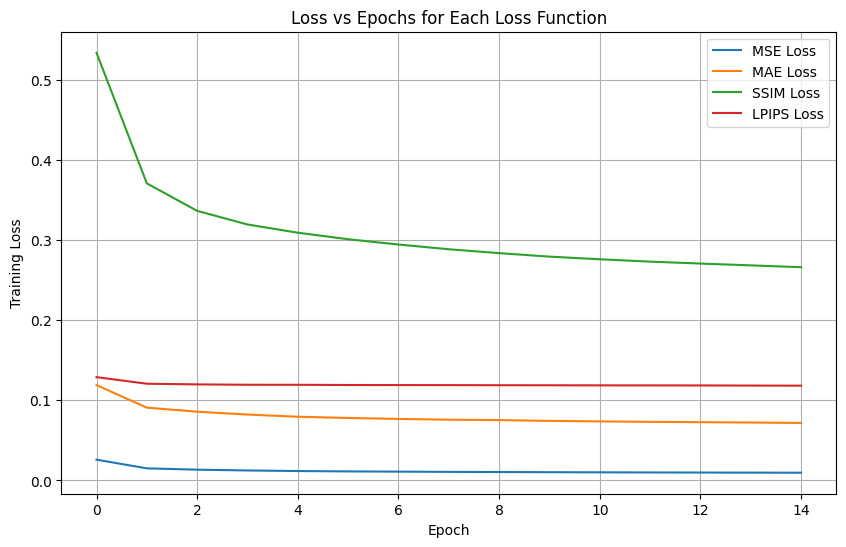

In [31]:
plt.figure(figsize=(10,6))
plt.plot(mse_curve, label="MSE Loss")
plt.plot(mae_curve, label="MAE Loss")
plt.plot(ssim_curve, label="SSIM Loss")
plt.plot(lpips_curve, label="LPIPS Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss vs Epochs for Each Loss Function")
plt.legend()
plt.grid(True)
plt.show()


## Evaluate Model Using ALL Distance Metrics

In [32]:
def evaluate_model(model):
    model.eval()

    mse_total = ssim_total = lp_total = 0
    cos_total = gmsd_total = comb_total = 0
    de_total = 0
    count = 0

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            recon, bins = model(imgs)

            mse_total   += mse_loss(recon, imgs).item()
            ssim_total  += ssim(recon, imgs, data_range=1.0, size_average=True).item()
            lp_total    += lpips_loss(to_lpips_range(recon), to_lpips_range(imgs)).mean().item()
            cos_total   += cosine_distance(imgs, recon).item()
            gmsd_total  += gmsd_distance(imgs, recon).item()
            de_total    += deltaE2000_distance(imgs, recon)
            comb_total  += combined_distance(imgs, recon)

            count += 1

    return {
      "MSE": mse_total / count,
      "SSIM": ssim_total / count,
      "LPIPS": lp_total / count,
      "Cosine": cos_total / count,
      "GMSD": gmsd_total / count,
      "DeltaE2000": de_total / count,
      "Combined": comb_total / count
  }


## Visualize Reconstructions

In [33]:
def visualize_model(model, title="Model Output"):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, bins = model(imgs)

    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    axs[0].imshow(
        vutils.make_grid(imgs[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[0].set_title("Original Images", fontsize=24)
    axs[0].axis("off")

    axs[1].imshow(
        vutils.make_grid(recon[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[1].set_title("Reconstructed Images", fontsize=24)
    axs[1].axis("off")

    plt.suptitle(title, fontsize=28)
    plt.tight_layout()
    plt.show()


## Run Visualizations

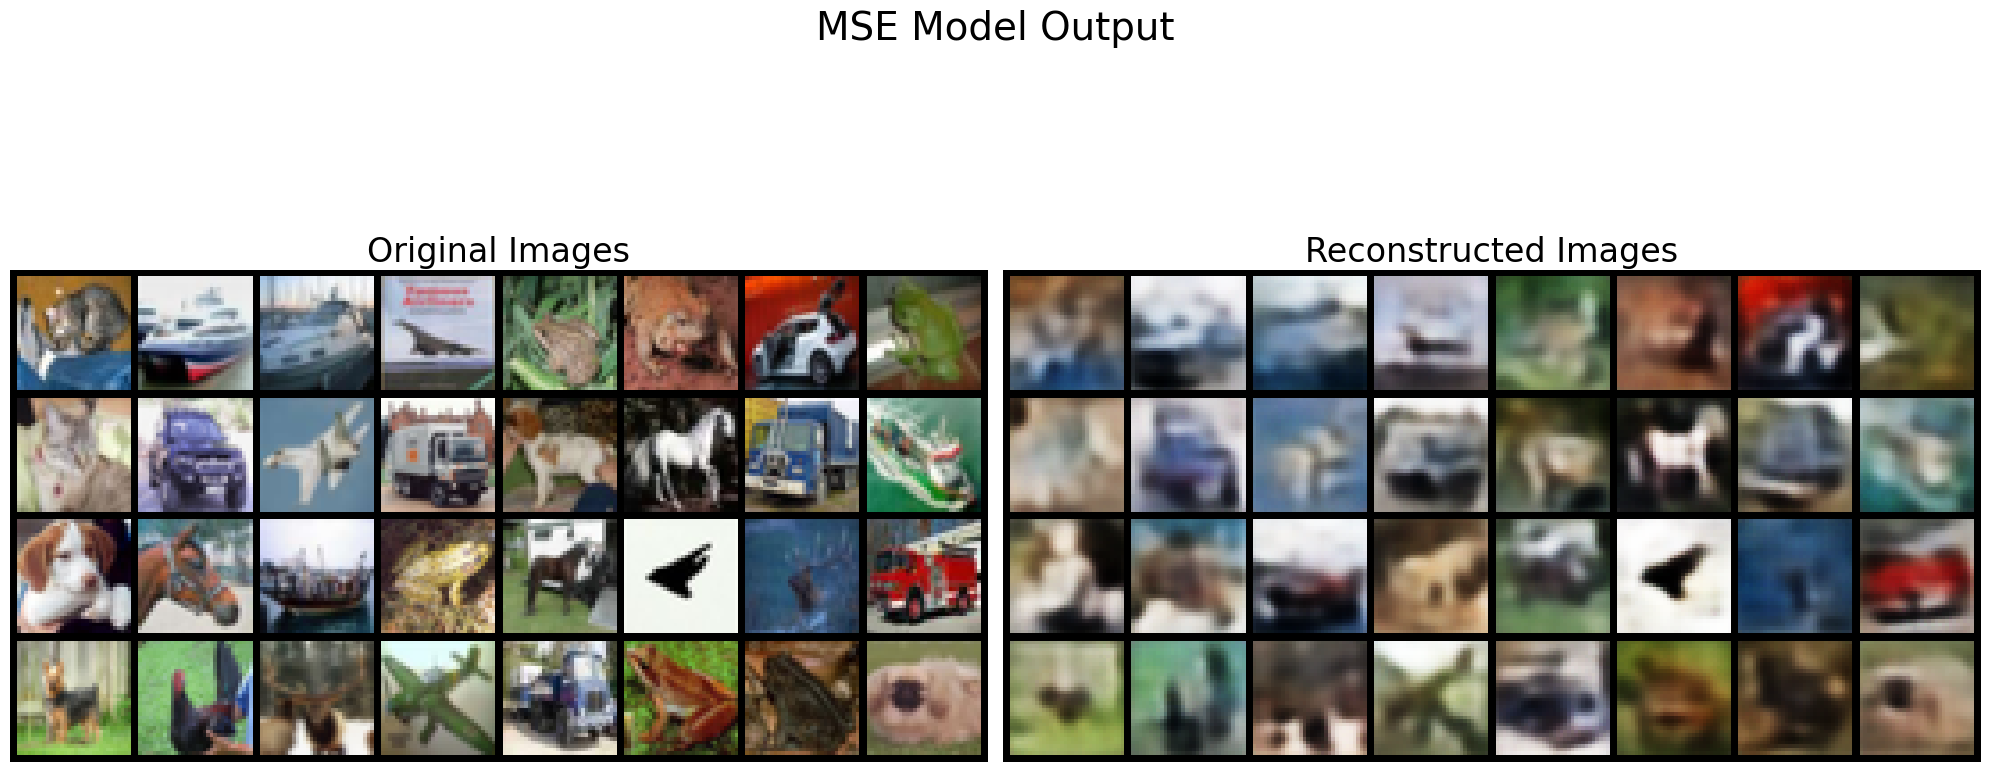

In [34]:
visualize_model(model_mse, "MSE Model Output")

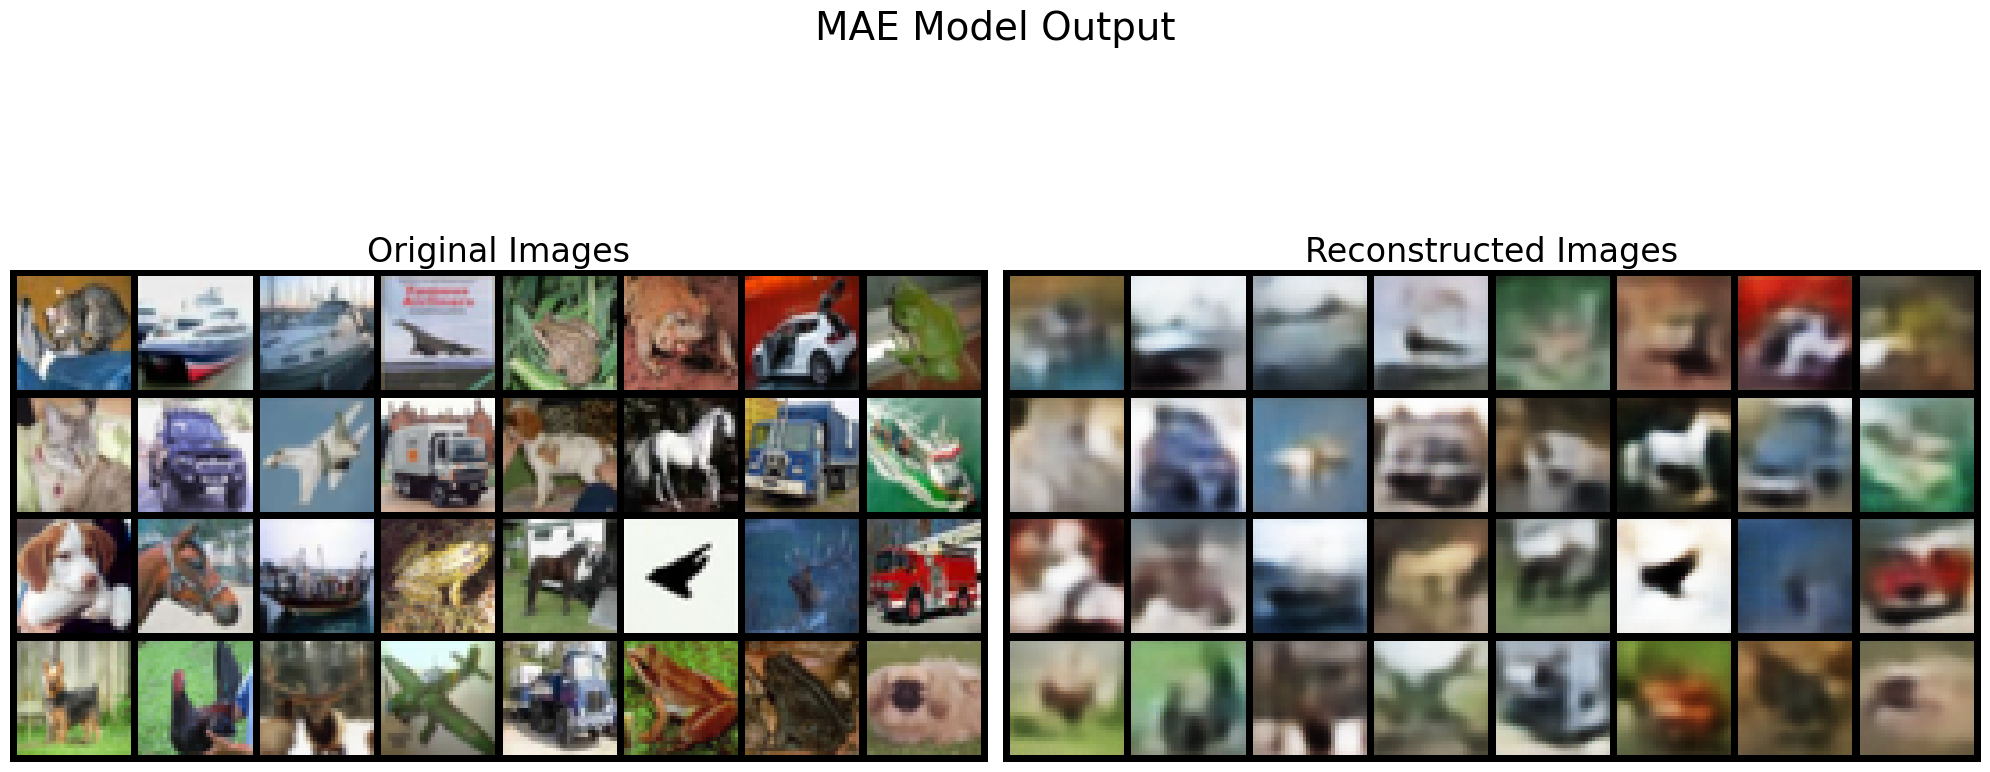

In [35]:
visualize_model(model_mae, "MAE Model Output")

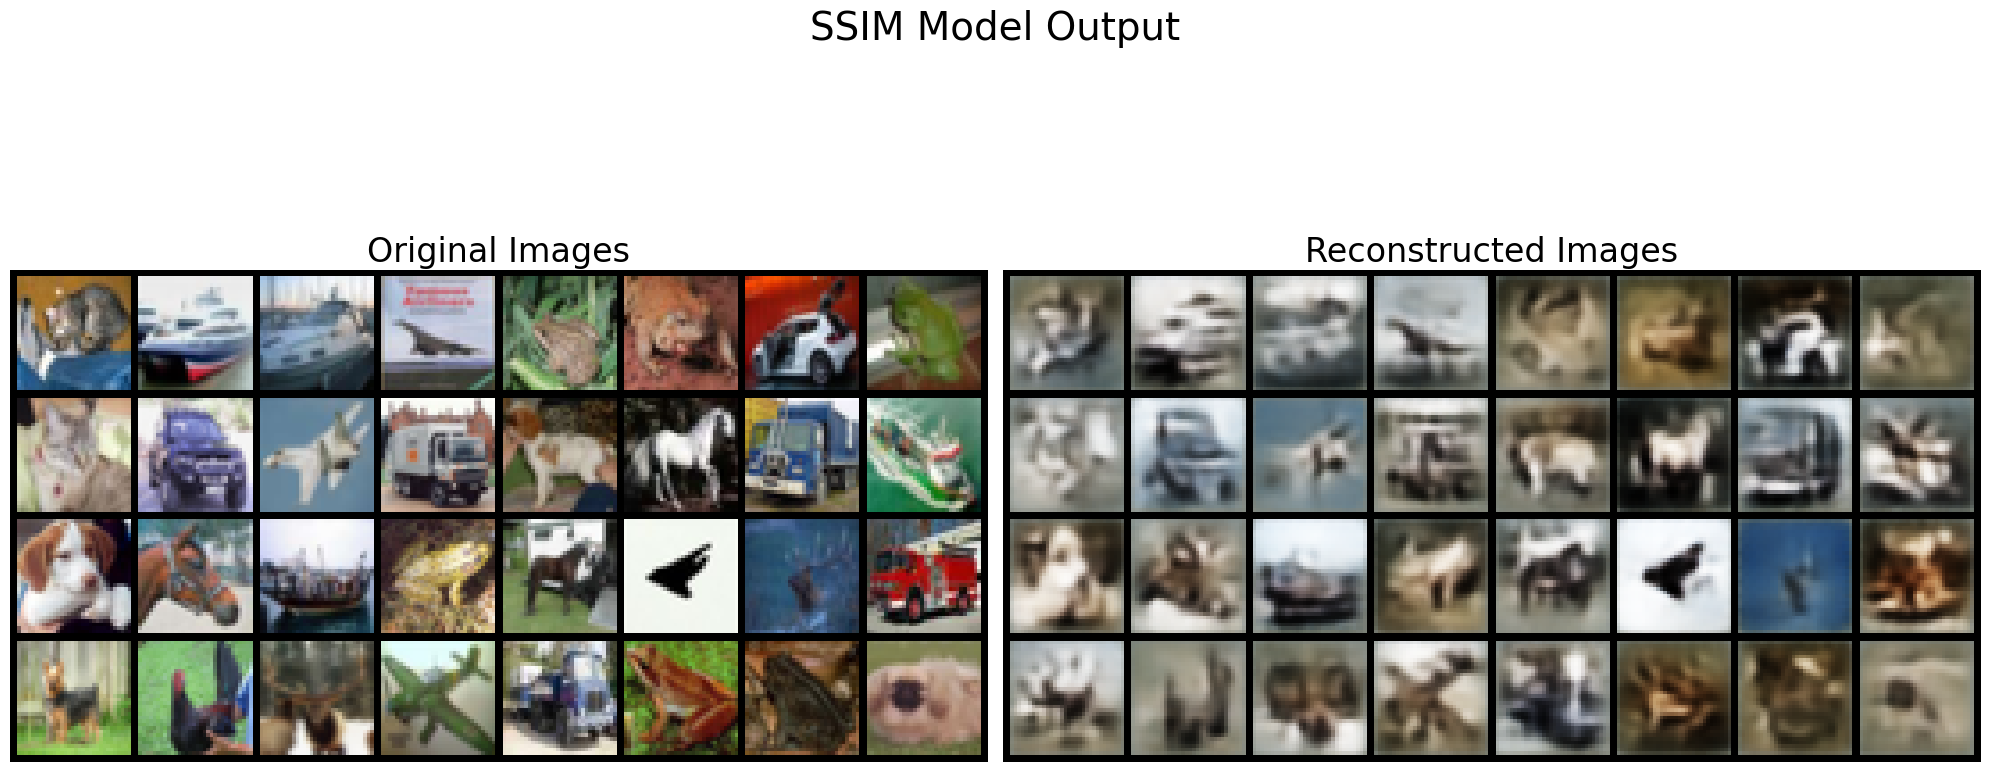

In [36]:
visualize_model(model_ssim, "SSIM Model Output")

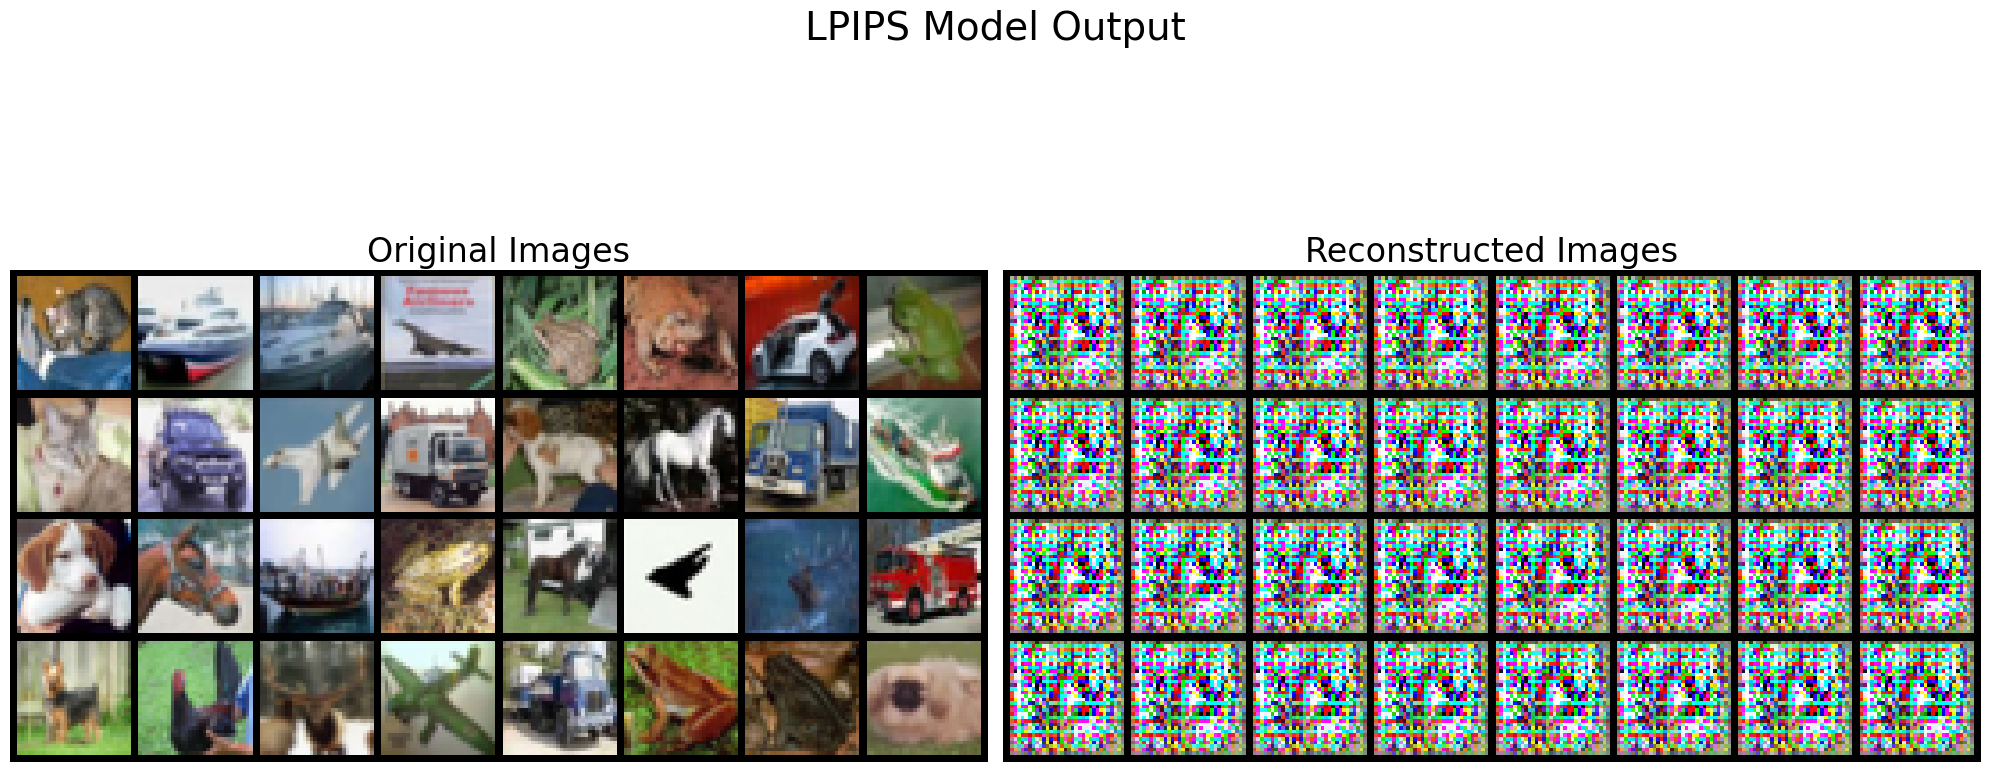

In [37]:
visualize_model(model_lpips, "LPIPS Model Output")

## Run Evaluations

In [38]:
import pandas as pd

df_results = pd.DataFrame({
    "MSE Loss Model": evaluate_model(model_mse),
    "MAE Loss Model": evaluate_model(model_mae),
    "SSIM Loss Model": evaluate_model(model_ssim),
    "LPIPS Loss Model": evaluate_model(model_lpips),
}).T

df_results

,MSE,SSIM,LPIPS,Cosine,GMSD,DeltaE2000,Combined
MSE Loss Model,0.010428,0.609936,0.176075,0.020646,0.128873,9.531775,0.193643
MAE Loss Model,0.010300,0.597472,0.184545,0.021031,0.130822,9.259569,0.200886
SSIM Loss Model,0.017823,0.726266,0.143452,0.033464,0.142677,12.959471,0.149540
LPIPS Loss Model,0.212226,0.005526,0.118809,0.249615,0.238321,41.760326,0.420750
